# Paper Simulations

Comprehensive parameter sweep for TU, strong, weak, and lexicographic heuristics across player counts, cohort sizes, and cycle limits.

In [1]:
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from instance_analysis import load_instance
from KEP_functions import (
    build_compat_graph,
    build_graph_features,
    make_partition,
    core_heuristic,
    strong_core_heuristic,
    core_tu_simple,
    lexicographic_core_search,
)


In [ ]:
PLAYER_GRID = [5, 10, 15, 20, 30]
NUM_PATIENTS_GRID = [
    {'label': '100', 'value': 100},
    {'label': '200', 'value': 200},
    {'label': '500', 'value': 500},
  #  {'label': 'max', 'value': 1000},
]
NUM_PATIENT_LABELS = [cfg['label'] for cfg in NUM_PATIENTS_GRID]
DELTAS = [2,3]
MAX_COAL_SIZE = 4
SOLVER = 'GUROBI'
INSTANCE_DIR = Path('instances_large')
FIGURE_DIR = Path('figures')
FIGURE_DIR.mkdir(exist_ok=True)


## Helper utilities

In [6]:
def stable_seed(*items) -> int:
    acc = 0
    for item in items:
        for ch in str(item):
            acc = (acc * 43 + ord(ch)) % (2**32)
    return acc


def run_simulation_case(instance_path, instance_data, features, num_pat_cfg, num_players, delta, solver=SOLVER):
    label = num_pat_cfg['label']
    target_value = num_pat_cfg['value']
    base_seed = stable_seed(instance_path.name, label, num_players, delta)
    rng_graph = np.random.default_rng(base_seed)
    try:
        vertices, adj_out, _, altruist_edges = build_compat_graph(
            instance_data, num_patients=target_value, rng=rng_graph
        )
    except ValueError as exc:
        print(f"Skipping {instance_path.name} | players {num_players} | Δ{delta} | {label}: {exc}")
        return None
    if not vertices:
        print(f"Skipping {instance_path.name} | players {num_players} | Δ{delta} | {label}: no vertices")
        return None

    partition = make_partition(
        vertices,
        num_players=num_players,
        var_size=1,
        rng=np.random.default_rng(base_seed + 1),
    )
    available_altruists = len(altruist_edges)

    tu_result = core_tu_simple(
        vertices,
        adj_out,
        partition,
        delta,
        max_coal_size=MAX_COAL_SIZE,
        solver=solver,
        rng=np.random.default_rng(base_seed + 2),
        altruist_edges=altruist_edges,
    )

    record = {
        'instance': instance_path.name,
        'num_players': num_players,
        'Delta': delta,
        'num_patients_label': label,
        'target_num_patients': target_value if target_value is not None else 'max',
        'actual_vertices': len(vertices),
        'available_altruists': available_altruists,
        'tu_altruists': tu_result.get('altruists_used', 0),
        'tu_in_core': tu_result.get('in_core', False),
        'tu_source': 'computed',
    }

    if record['tu_altruists'] == 0:
        record['strong_altruists'] = 0
        record['strong_in_core'] = True
        record['strong_source'] = 'inferred_from_tu_zero'
    else:
        strong_result = strong_core_heuristic(
            vertices,
            adj_out,
            partition,
            delta,
            solver=solver,
            max_coal_size=MAX_COAL_SIZE,
            rng=np.random.default_rng(base_seed + 3),
            altruist_edges=altruist_edges,
            max_altruists=max(available_altruists, 1),
        )
        record['strong_altruists'] = strong_result['altruists_added']
        record['strong_in_core'] = strong_result['final_in_core']
        record['strong_source'] = 'computed'

    if record['strong_altruists'] == 0:
        record['weak_altruists'] = 0
        record['weak_in_core'] = record['strong_in_core']
        record['weak_source'] = 'inferred_from_strong_zero'
    else:
        weak_result = core_heuristic(
            vertices,
            adj_out,
            partition,
            delta,
            solver=solver,
            max_coal_size=MAX_COAL_SIZE,
            rng=np.random.default_rng(base_seed + 4),
            altruist_edges=altruist_edges,
            max_altruists=max(available_altruists, 1),
        )
        record['weak_altruists'] = weak_result['altruists_added']
        record['weak_in_core'] = weak_result['final_in_core']
        record['weak_source'] = 'computed'

    lex_result = lexicographic_core_search(
        vertices,
        adj_out,
        partition,
        delta,
        graph_features=features,
        max_coal_size=MAX_COAL_SIZE,
        solver=solver,
        altruist_edges=altruist_edges,
        rng=np.random.default_rng(base_seed + 5),
    )
    record['lex_altruists'] = lex_result['altruists_added']
    record['lex_in_core'] = lex_result['final_in_core']
    record['lex_transplants'] = lex_result['objective_tiers'].get('transplants', 0)
    record['lex_cycle_count'] = lex_result['objective_tiers'].get('cycle_count', 0)

    return record


## Run simulation grid

In [7]:
simulation_records = []
instance_cache = {}
for instance_path in sorted(INSTANCE_DIR.glob('genxml-*.xml')):
    instance = load_instance(instance_path)
    features = build_graph_features(instance)
    for cfg in NUM_PATIENTS_GRID:
        print(f"Running cases for {instance_path.name} | num_patients {cfg['label']}")
        for delta in DELTAS:
            for num_players in PLAYER_GRID:
                rec = run_simulation_case(
                    instance_path, instance, features, cfg, num_players, delta, solver=SOLVER
                )
                if rec is not None:
                    simulation_records.append(rec)
    print(f"Completed {instance_path.name}: total cases so far {len(simulation_records)}")

results_df = pd.DataFrame(simulation_records)
results_df


Running cases for genxml-0.xml | num_patients 100
Running cases for genxml-0.xml | num_patients 200
Running cases for genxml-0.xml | num_patients 500
Completed genxml-0.xml: total cases so far 15
Running cases for genxml-1.xml | num_patients 100
Running cases for genxml-1.xml | num_patients 200
Running cases for genxml-1.xml | num_patients 500
Completed genxml-1.xml: total cases so far 30
Running cases for genxml-2.xml | num_patients 100
Running cases for genxml-2.xml | num_patients 200
Running cases for genxml-2.xml | num_patients 500
Completed genxml-2.xml: total cases so far 45
Running cases for genxml-3.xml | num_patients 100
Running cases for genxml-3.xml | num_patients 200
Running cases for genxml-3.xml | num_patients 500
Completed genxml-3.xml: total cases so far 60
Running cases for genxml-4.xml | num_patients 100
Running cases for genxml-4.xml | num_patients 200
Running cases for genxml-4.xml | num_patients 500
Completed genxml-4.xml: total cases so far 75
Running cases for ge

,instance,num_players,Delta,num_patients_label,target_num_patients,actual_vertices,available_altruists,tu_altruists,tu_in_core,tu_source,strong_altruists,strong_in_core,strong_source,weak_altruists,weak_in_core,weak_source,lex_altruists,lex_in_core,lex_transplants,lex_cycle_count
0,genxml-0.xml,5,2,100,100,100,53,0,True,computed,0,True,inferred_from_tu_zero,0,True,inferred_from_strong_zero,0,True,30.0,15.0
1,genxml-0.xml,10,2,100,100,100,53,0,True,computed,0,True,inferred_from_tu_zero,0,True,inferred_from_strong_zero,0,True,26.0,13.0
2,genxml-0.xml,15,2,100,100,100,53,1,True,computed,1,True,computed,0,True,computed,0,True,34.0,17.0
3,genxml-0.xml,20,2,100,100,100,53,0,True,computed,0,True,inferred_from_tu_zero,0,True,inferred_from_strong_zero,0,True,40.0,20.0
4,genxml-0.xml,30,2,100,100,100,53,1,True,computed,2,True,computed,0,True,computed,0,True,26.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,genxml-9.xml,5,2,500,500,500,53,0,True,computed,0,True,inferred_from_tu_zero,0,True,inferred_from_strong_zero,0,True,348.0,174.0
146,genxml-9.xml,10,2,500,500,500,53,0,True,computed,0,True,inferred_from_tu_zero,0,True,inferred_from_strong_zero,0,True,356.0,178.0
147,genxml-9.xml,15,2,500,500,500,53,0,True,computed,0,True,inferred_from_tu_zero,0,True,inferred_from_strong_zero,0,True,332.0,166.0
148,genxml-9.xml,20,2,500,500,500,53,0,True,computed,0,True,inferred_from_tu_zero,0,True,inferred_from_strong_zero,0,True,350.0,175.0


In [ ]:
results_df = pd.DataFrame(simulation_records)
results_df
RESULTS_CSV = FIGURE_DIR / 'paper_simulations_results.csv'
results_df.to_csv(RESULTS_CSV, index=False)
RESULTS_CSV


WindowsPath('figures/paper_simulations_results.csv')

## Summary tables

In [ ]:
algo_cols = ['tu_altruists', 'strong_altruists', 'weak_altruists', 'lex_altruists']
summary_table = (
    results_df
    .groupby(['Delta', 'num_patients_label', 'num_players'])[algo_cols]
    .mean()
    .round(2)
)
display(summary_table)
summary_path = FIGURE_DIR / 'altruist_summary.csv'
summary_table.to_csv(summary_path)
summary_path


tu_altruists  strong_altruists  \
Delta num_patients_label num_players                                   
2     100                5                    0.00              0.00   
                         10                   0.00              0.00   
                         15                   0.17              0.17   
                         20                   0.33              0.83   
                         30                   0.50              0.67   
      200                5                    0.00              0.00   
                         10                   0.00              0.00   
                         15                   0.00              0.00   
                         20                   0.00              0.00   
                         30                   0.00              0.00   
3     100                5                    0.00              0.00   
                         10                   0.00              0.00   
                         15                   0.00              0.00   
                         20                   0.17              0.00   
                         30                   0.00              0.00   
      200                5                    0.00              0.00   
                         10                   0.00              0.00   
                         15                   0.00              0.00   
                         20                   0.00              0.00   
                         30                   0.00              0.00   

                                      weak_altruists  lex_altruists  
Delta num_patients_label num_players                                 
2     100                5                       0.0           0.00  
                         10                      0.0           0.00  
                         15                      0.0           0.00  
                         20                      0.0           0.50  
                         30                      0.0           0.67  
      200                5                       0.0           0.00  
                         10                      0.0           0.00  
                         15                      0.0           0.00  
                         20                      0.0           0.00  
                         30                      0.0           0.00  
3     100                5                       0.0           0.00  
                         10                      0.0           0.00  
                         15                      0.0           0.00  
                         20                      0.0           0.17  
                         30                      0.0           0.00  
      200                5                       0.0           0.00  
                         10                      0.0           0.00  
                         15                      0.0           0.00  
                         20                      0.0           0.00  
                         30                      0.0           0.00

WindowsPath('figures/altruist_summary.csv')

In [ ]:
summary_table_max = (
    results_df
    .groupby(['Delta', 'num_patients_label', 'num_players'])[algo_cols]
    .max()
    .round(2)
)
display(summary_table_max)
summary_path = FIGURE_DIR / 'altruist_summary_max.csv'
summary_table_max.to_csv(summary_path)
summary_path

tu_altruists  strong_altruists  \
Delta num_patients_label num_players                                   
2     100                5                       0                 0   
                         10                      0                 0   
                         15                      1                 1   
                         20                      2                 5   
                         30                      1                 2   
      200                5                       0                 0   
                         10                      0                 0   
                         15                      0                 0   
                         20                      0                 0   
                         30                      0                 0   
3     100                5                       0                 0   
                         10                      0                 0   
                         15                      0                 0   
                         20                      1                 0   
                         30                      0                 0   
      200                5                       0                 0   
                         10                      0                 0   
                         15                      0                 0   
                         20                      0                 0   
                         30                      0                 0   

                                      weak_altruists  lex_altruists  
Delta num_patients_label num_players                                 
2     100                5                         0              0  
                         10                        0              0  
                         15                        0              0  
                         20                        0              2  
                         30                        0              3  
      200                5                         0              0  
                         10                        0              0  
                         15                        0              0  
                         20                        0              0  
                         30                        0              0  
3     100                5                         0              0  
                         10                        0              0  
                         15                        0              0  
                         20                        0              1  
                         30                        0              0  
      200                5                         0              0  
                         10                        0              0  
                         15                        0              0  
                         20                        0              0  
                         30                        0              0

WindowsPath('figures/altruist_summary_max.csv')

## Plots

WindowsPath('figures/altruists_vs_players.png')

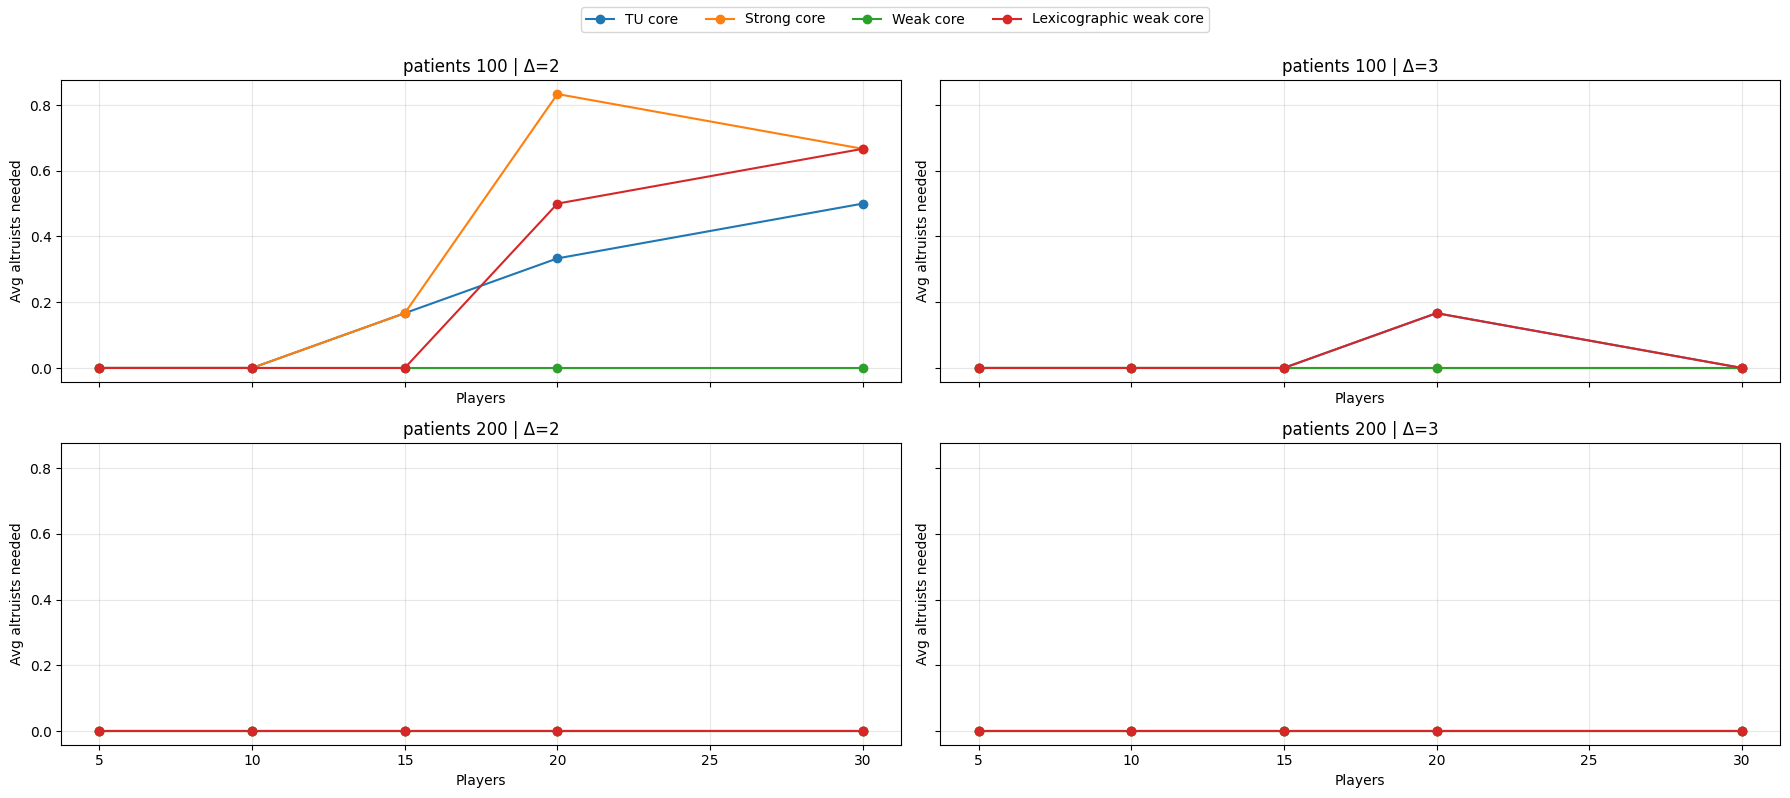

In [ ]:
algo_labels = {
    'tu_altruists': 'TU core',
    'strong_altruists': 'Strong core',
    'weak_altruists': 'Weak core',
    'lex_altruists': 'Lexicographic weak core',
}
fig, axes = plt.subplots(len(NUM_PATIENT_LABELS), len(DELTAS), figsize=(18, 4 * len(NUM_PATIENT_LABELS)), sharex=True, sharey=True)
if len(NUM_PATIENT_LABELS) == 1:
    axes = axes.reshape(1, -1)
for i, label in enumerate(NUM_PATIENT_LABELS):
    for j, delta in enumerate(DELTAS):
        ax = axes[i][j]
        subset = results_df[(results_df['num_patients_label'] == label) & (results_df['Delta'] == delta)]
        if subset.empty:
            ax.set_visible(False)
            continue
        for key, display_name in algo_labels.items():
            grouped = subset.groupby('num_players')[key].mean().sort_index()
            ax.plot(grouped.index, grouped.values, marker='o', label=display_name)
        ax.set_title(f"patients {label} | Δ={delta}")
        ax.set_xlabel('Players')
        ax.set_ylabel('Avg altruists needed')
        ax.grid(True, alpha=0.3)
handles, labels = axes[0][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
fig.tight_layout(rect=(0, 0, 1, 0.95))
line_fig_path = FIGURE_DIR / 'altruists_vs_players.png'
fig.savefig(line_fig_path, dpi=200)
line_fig_path


[WindowsPath('figures/tu_altruists_heatmap.png'),
 WindowsPath('figures/strong_altruists_heatmap.png'),
 WindowsPath('figures/weak_altruists_heatmap.png'),
 WindowsPath('figures/lex_altruists_heatmap.png')]

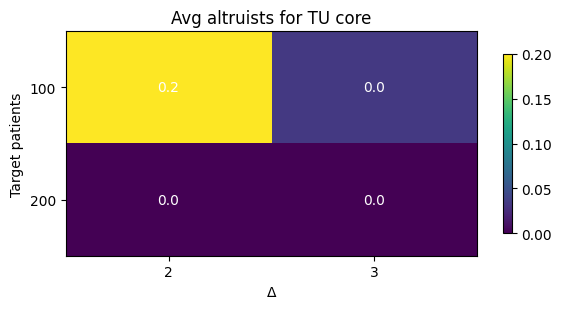

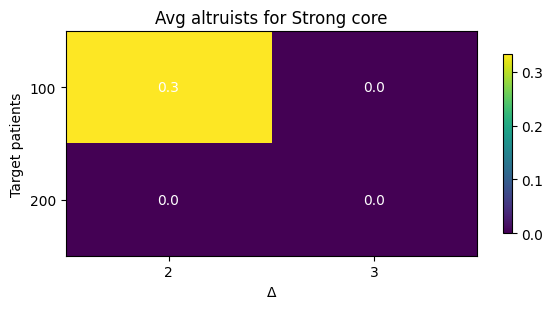

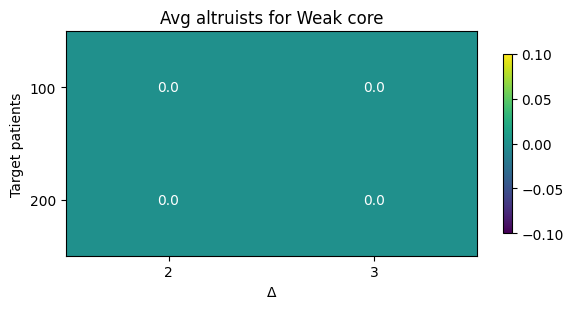

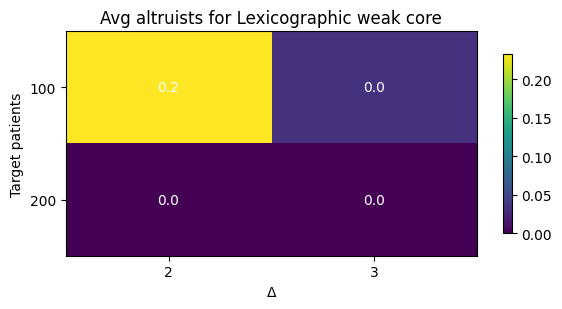

In [ ]:
heatmap_paths = []
for key, display_name in algo_labels.items():
    pivot = (
        results_df.groupby(['num_patients_label', 'Delta'])[key]
        .mean()
        .unstack('Delta')              # turn Δ into columns first
        .reindex(index=NUM_PATIENT_LABELS)
        .reindex(columns=DELTAS)       # enforce Δ ordering
    )
    if pivot.empty:
        continue

    data = np.atleast_2d(pivot.values)
    fig, ax = plt.subplots(figsize=(6, 0.6 * len(pivot.index) + 2))
    im = ax.imshow(data, aspect='auto', cmap='viridis')
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel('Δ')
    ax.set_ylabel('Target patients')
    ax.set_title(f"Avg altruists for {display_name}")
    for (row, col), val in np.ndenumerate(data):
        if np.isfinite(val):
            ax.text(col, row, f"{val:.1f}", ha='center', va='center', color='white')
    fig.colorbar(im, ax=ax, shrink=0.8)
    fig.tight_layout()
    path = FIGURE_DIR / f"{key}_heatmap.png"
    fig.savefig(path, dpi=200)
    heatmap_paths.append(path)

heatmap_paths


## Saved outputs

In [ ]:
sorted(path.name for path in FIGURE_DIR.glob('*.png'))
